<a href="https://colab.research.google.com/github/stepanl-bsy/langgraph_tutorial/blob/main/3_lang_langgraph_essay_writer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q langgraph  langchain langchain_community langchain_google_genai tavily-python
# google-cloud-aiplatform vertexai langgraph langchain_google_vertexai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00


## langchain vs langgraph

langchain = easy to set up, a good place to start

langgraph = more complex workflows, more control

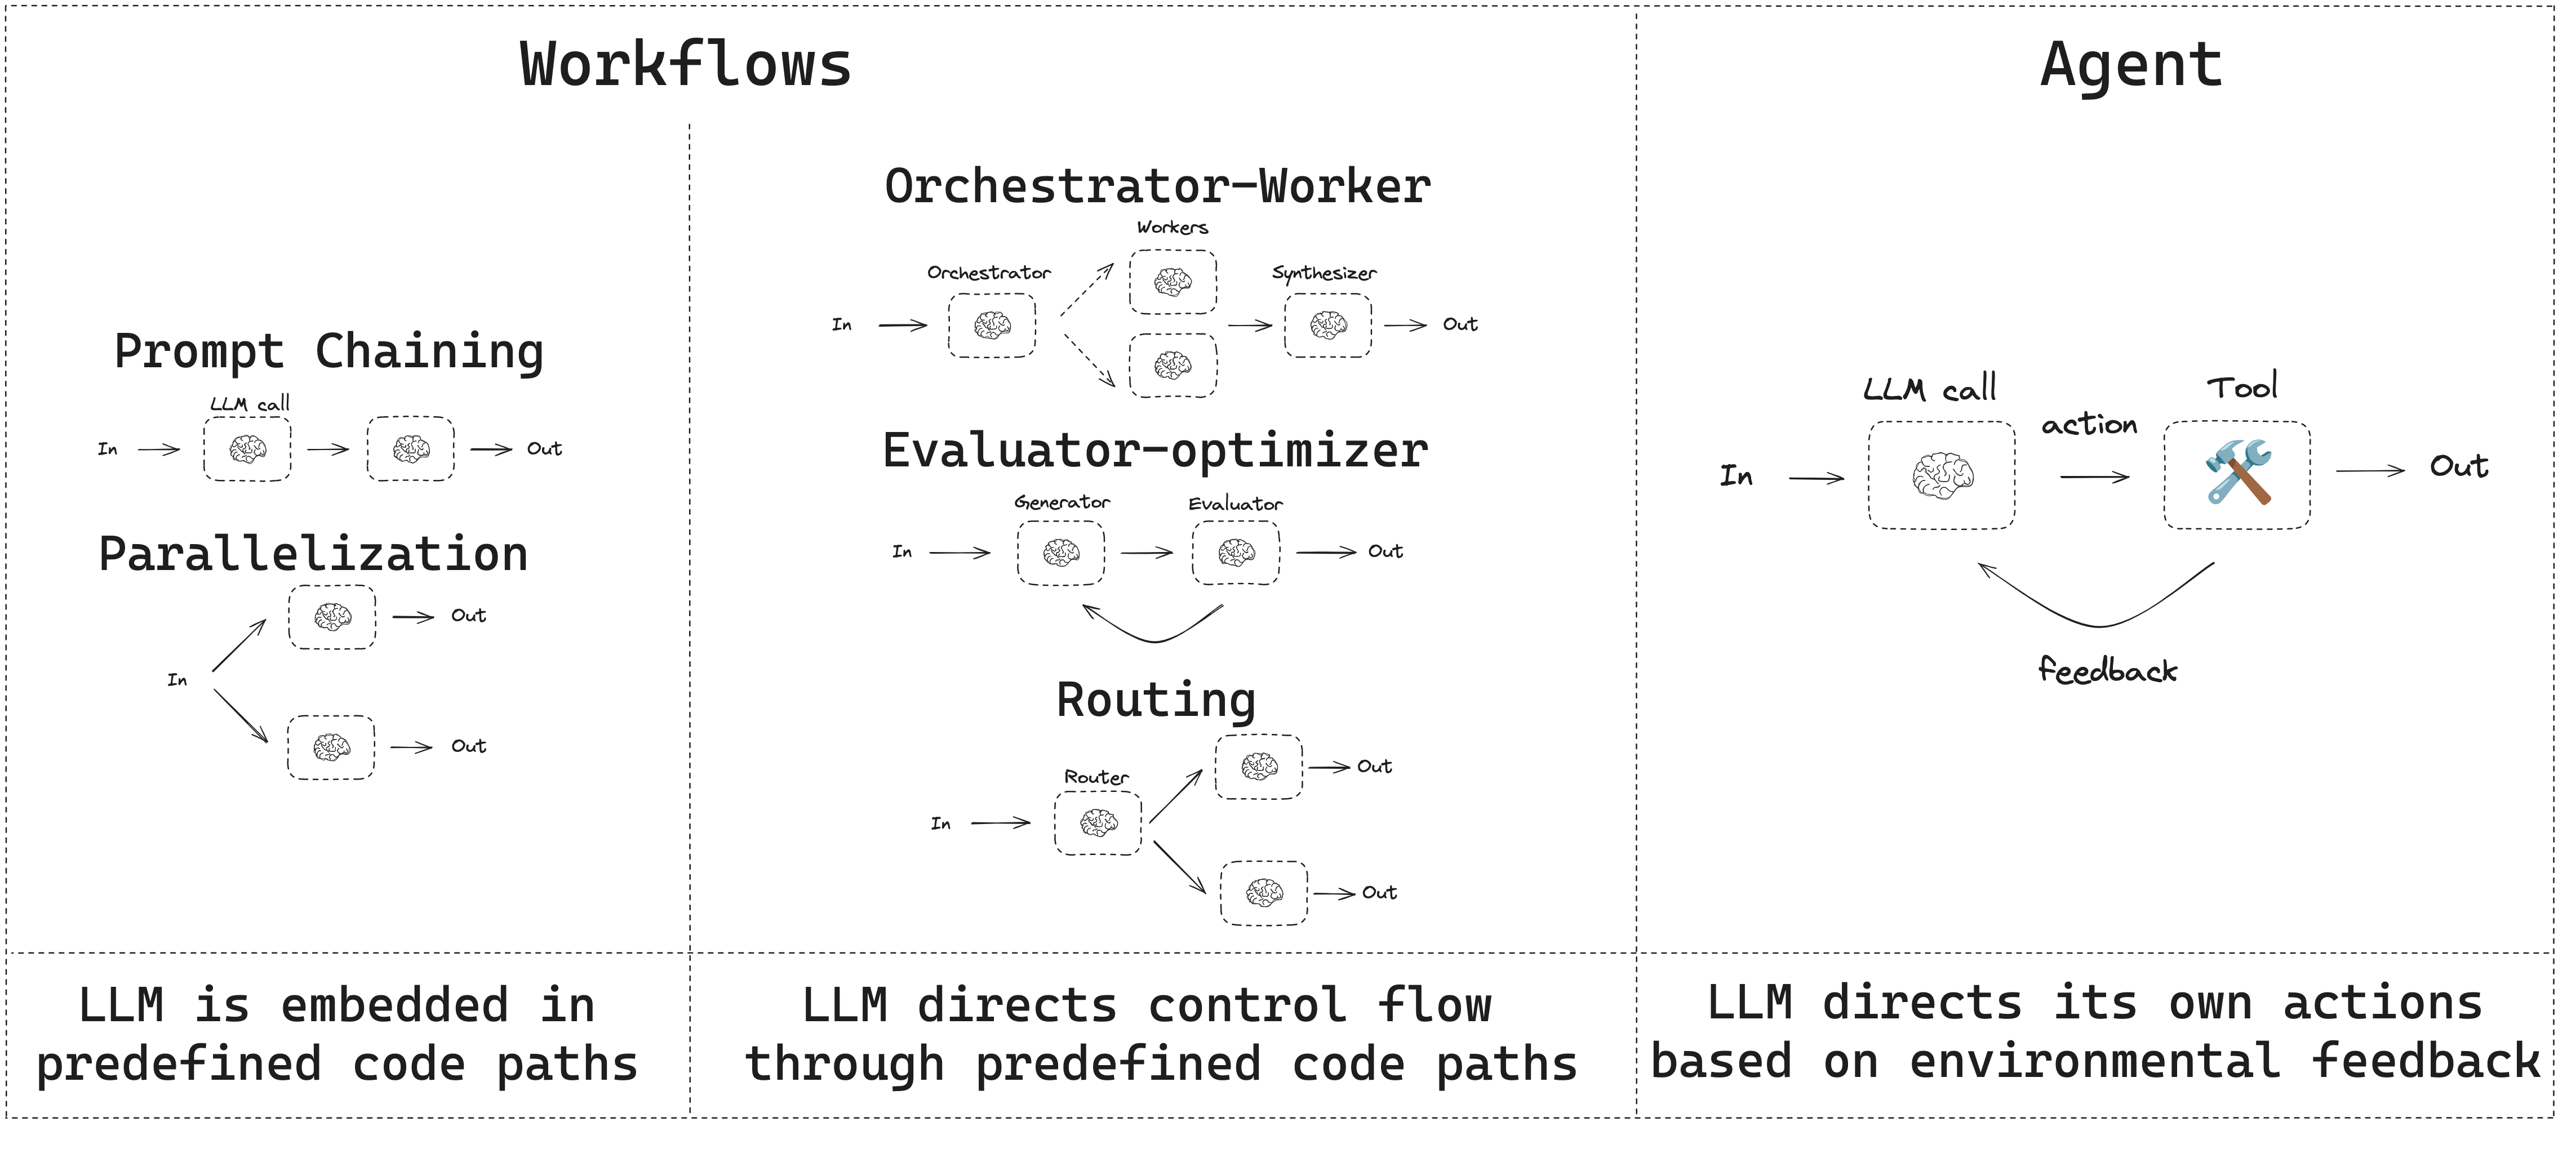

If you're looking for learning material, I would recommend taking these free courses. They will gradually introduce you to langchain, agents, rag (i.e. embedding search) and all the other concepts and tools around these topics.

#### Langchain:
https://www.deeplearning.ai/short-courses/langchain-chat-with-your-data/

https://www.deeplearning.ai/short-courses/langchain-for-llm-application-development/

#### Langgraph:
https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/

https://github.com/grbcool/AI-Agents-in-the-LangGraph/


## Essay Writer demo


## Multiagent langgraph
 - Build complex apps
 - Each node can be an agent or a function
 - Function call chaos mitigation
   - LLMs at this point can handle this with function calling, but these functions might not be chained correctly by the llm
   - Google advices not using more than ~5 tools for functionc calling for this reason. It can get too chaotic for the model to choose correct ones, since it goes off by their descriptions
   - Restricting specific tools to certain nodes decreases this chaos


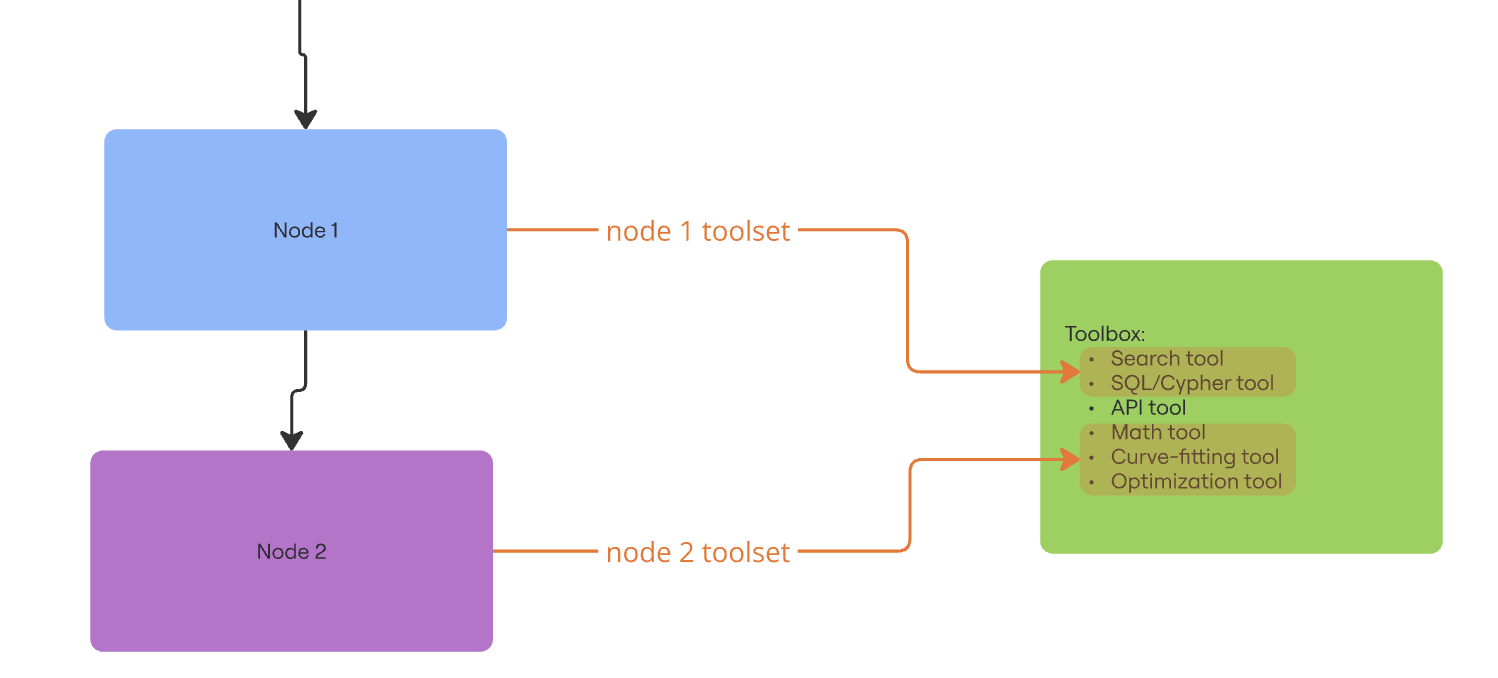

 - Build validators and safety switches
   - That's possible to do with regular agent workflows, but much more convinient with nodes
   - Example: The LLM app I'm working on has a funnel-like validation. Very rough checks at first on llm output with regex, then stricter and stricter as we get deeper into the graph

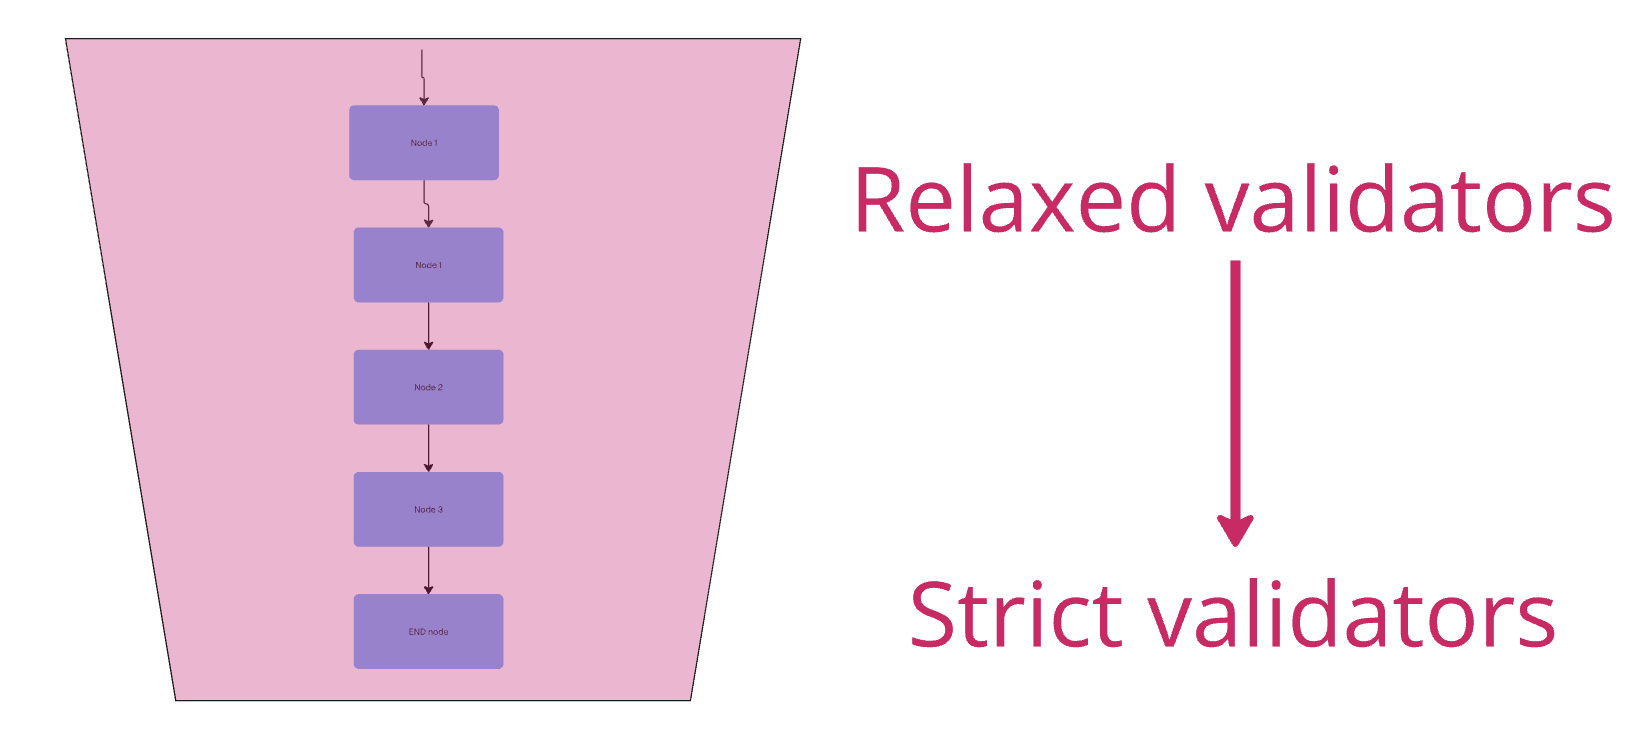

 - I don't know situation. Confine the model to what it can output and what is can't programmatically. If it doesn't know the answer, default it to "I don't know" type of an answer

 - Build custom Query Analysis tools and patterns

 - Control node execution/re-execution /error handling:
     - Example of node re-execution /: For an LLM app I'm working on right now, I allow a node to be re-run if there is an error. LLM is instantiated with non-zero temperature, so it's likely to generate a result that's a bit different.

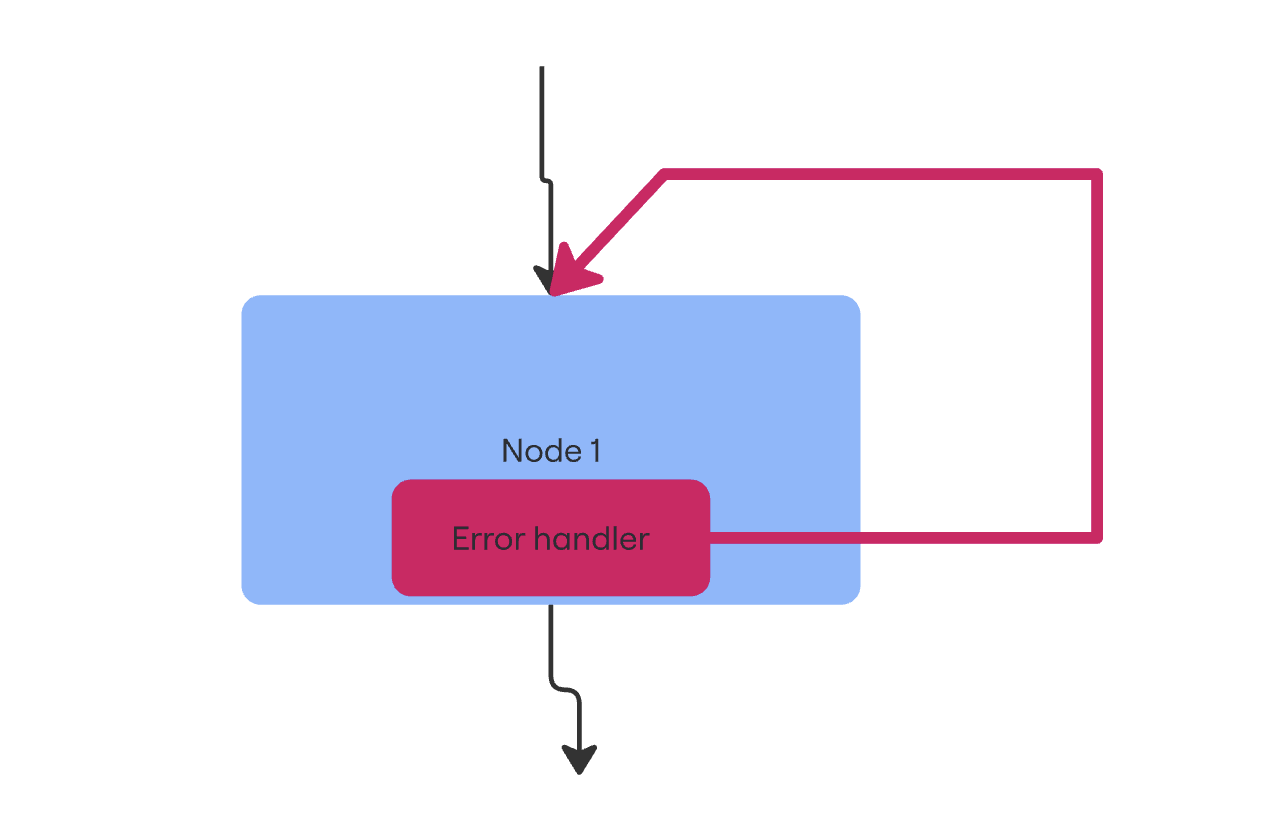

   - Multiagent essay writer is a more complex version of this approach
     - We have a reflect and critique agents that can modify the essay (or a code-generating-prompt) and re-run it untill all errors are resolved
     - We can incorporate/rephrase the error into the instructions to help it avoid this particular error on a new run. We can use an agent to rephrase the promt into instructions and modify the Node 1 with these instructions
     - For this demo, we will ask the essay writer langgraph ""what is the difference in challenges drilling operations face in Mining and Oil&gas""

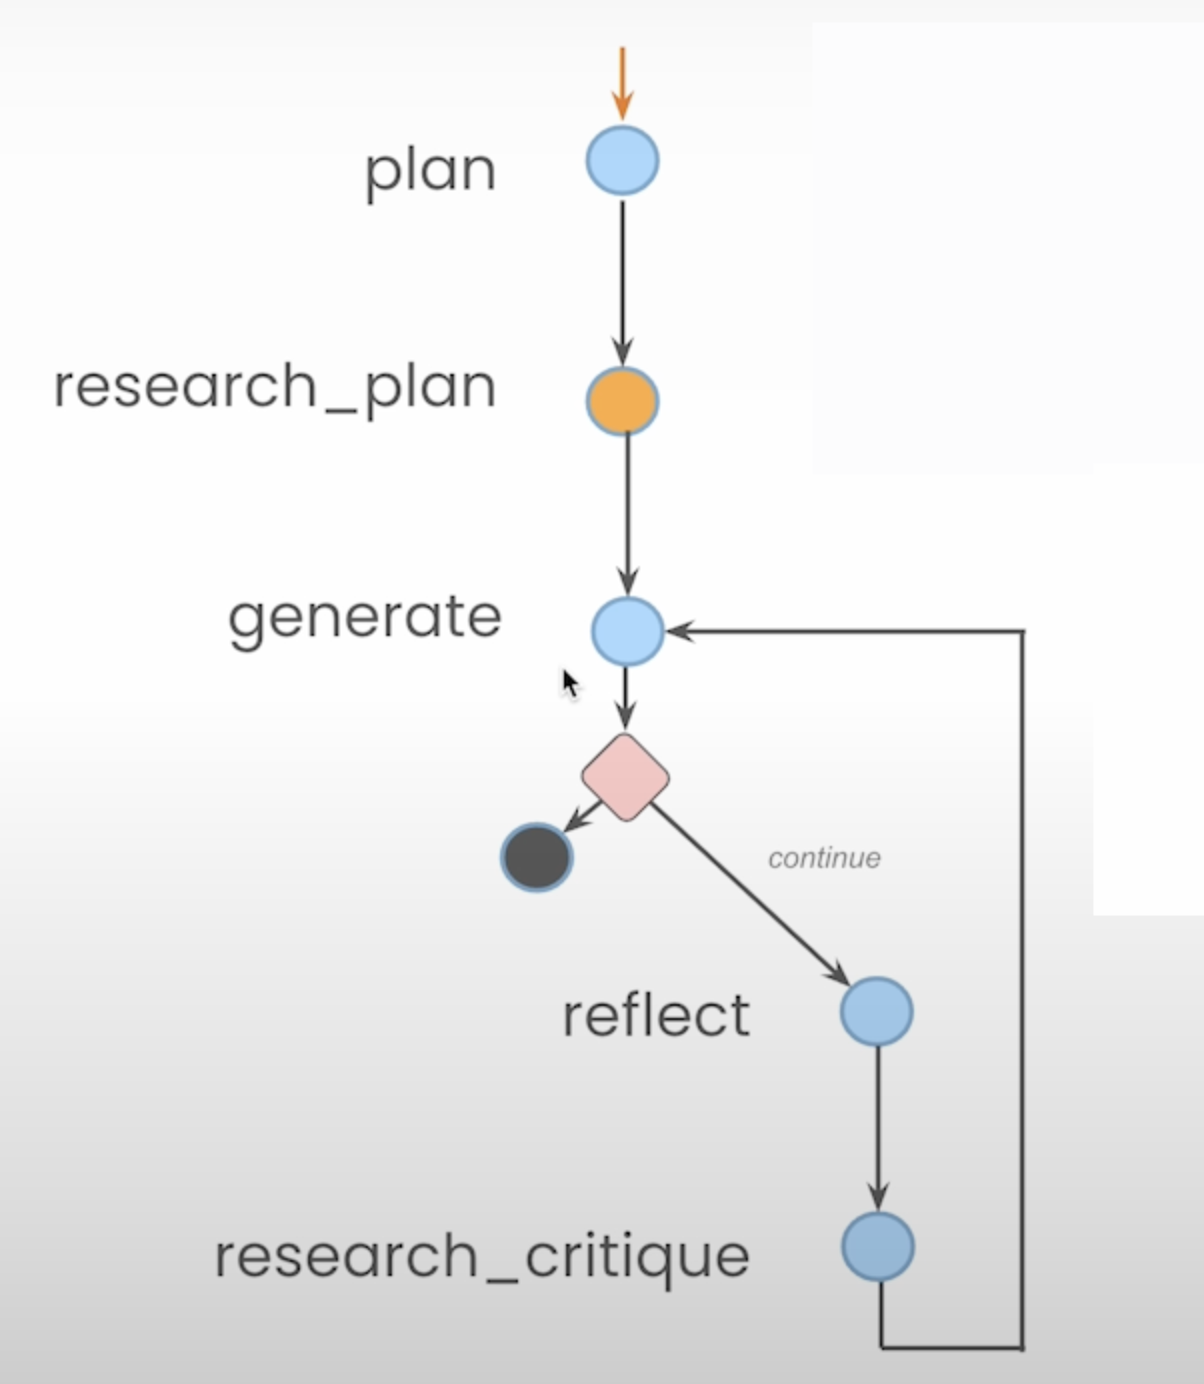

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage





## Agent State definition
 - That's essentially a dict of what we'd like to store in-memory during graph execution
 - All nodes will have access to this agent state via state['task'], state['plan'], etc
 - Any node return will be passed to the state. So, if a node is defined as a method with return {'task': 'abctask'}, we will update the task with 'abctask'
 - We use revision_number and max_revisions to keep track of how many essay re-writes we want to have and how many we have completed already
 - The other keys keep track of each nodes' output - drafts, revisions etc

In [ ]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

## Instantiate Gemini

In [ ]:


# ### LLM setup
# PROJECT_ID = "seequent-labs-dev"  # @param {type:"string"}
# LOCATION = "us-west1"  # @param {type:"string"}

# import vertexai

# vertexai.init(project=PROJECT_ID, location=LOCATION)
# from langchain_google_vertexai import ChatVertexAI

# model = ChatVertexAI(model="gemini-1.5-pro-001",temperature=0.3 , verbose=False)




In [ ]:
import re
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}=")


_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("GOOGLE_API_KEY")

TAVILY_API_KEY=··········
GOOGLE_API_KEY=··········


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)

## Prompts


### PLAN_PROMPT
 - Writes a plan for the essay

In [ ]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

### RESEARCH_PLAN_PROMPT
 - After making a plan, generate proper research questions (3 max here)
 - These will fetch the evidence we need to write an essay
 - Pass them to tavily search api

In [ ]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max.\
Each query should be one full sentence."""


### WRITER_PROMPT
 - Writes the essay based on researched content

In [ ]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed:

------

{content}"""

### REFLECTION_PROMPT
 - Critiquing the essay draft

In [ ]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

### RESEARCH_CRITIQUE_PROMPT
 - After the critique is ready, we have to modify the results
 - These have to based on some evidence
 - We ask LLM to geneate search queries to gather this evidence here and pass them to tavily search api

In [ ]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.\
Each query should be one full sentence."""


## Structured output (langchain) / Controlled response (google)
  - When I want the model output to be json or some other specific format, in langchain I can just call ```model.with_structured_output(Queries)```. ```Queries``` is a ```BaseModel``` class defining the output.
 - Gemini vs OpenAI differences:
   - Gemini needs explicit instructions. For example, I have to add
   "Each query should be one full sentence." to Gemini (otherwise I can get empty responses), but I don't have to ChatGPT.
 With Gemini, this class also needs a proper docstring and formatting instructions - even though instructions don't mention it https://ai.google.dev/gemini-api/docs/structured-output?lang=python

In [ ]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    """A list of queries for the researcher

    **Format:**

    queries: ['query1', 'query2',...]
    """
    queries: List[str]

## Search client instantiation

In [ ]:

from tavily import TavilyClient

import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])



### Provide options if throttled by the free search api
 - Tavily free api throttles at 100 requests per minuite
 - There could be a chracter-length constrain as well
 - We also introduce uneveness in search request delay to avoid being throttled

In [ ]:

# import time
# import random
# import re

# def call_tavily(tool_input):
#     """
#     Calls the Tavily search API with error handling and retries, input sanitization,
#     and adherence to the rate limit of 100 requests per minute (free API throttling).
#     """
#     delay = 60 / 100  # Calculate delay for 100 requests per minute
#     max_retries = 5  # Adjust as needed
#     # max_length = 10000  # Character limit

#     # Sanitize the input:
#     tool_input = re.sub(r'[^\w\s-]', '', tool_input)
#     # tool_input = tool_input[:max_length]  # Truncate to the maximum length

#     for attempt in range(max_retries):
#         try:
#             result = tavily.search(tool_input)
#             time.sleep(delay)  # Wait to respect the rate limit
#             return result
#         except HTTPError as e:
#             if e.code == 429:  # Too Many Requests
#                 delay *= 2  # Increase delay if rate limit is hit
#                 jitter = random.uniform(0, 1)
#                 time.sleep(delay + jitter)
#             elif e.code == 400:  # Bad Request
#                 print(f"Tavily Bad Request Error: {e}")
#                 # More detailed error handling could be added here
#             else:
#                 raise
#     raise Exception("Failed after multiple retries")

## Agent definitions
 - It makes sense to think about agents as personas (people with different responsibilties/job duties)
 - We define these job duties / personas in system prompts

In [ ]:
def plan_node(state: AgentState):
    """
    Initial, high-level essay planner persona.
     - Will generate an essay plan for us, something like:
      - Intro:
           - Talk about this point
           - State the purpose of the essay, etc
      - Discuission:
           - Research this point, etc
    """
    messages = [
        SystemMessage(content=PLAN_PROMPT), # plan prompt template
        HumanMessage(content=state['task']) # Human input - "what is the difference in challenges drilling operations face in Mining and Oil&gas"
    ]
    response = model.invoke(messages)
    print('---'*5)   # visualize the inputs for demo purposes
    print(f'Plan Node. \n')
    print(f'messages: {messages}\n')
    print(f'response.content: {response.content}\n')
    print('---'*5)
    return {"plan": response.content}

In [ ]:
def research_plan_node(state: AgentState):
    """
    Researcher persona.
     - Generate search queries based on the essay plan provided.

     - We use model.with_structured_output(Queries) to MAKE THE MODEL output a List of strings.
    That's what we call a structured output/ controlled response. See more here: https://ai.google.dev/gemini-api/docs/structured-output?lang=python

     - For example, we should get something like this (we set max number of queries at 3):
   ['What are the challenges specific to drilling operations in the mining industry?', 'What are the unique challenges faced in Oil and Gas drilling operations?', 'How do the geological conditions impact drilling operations differently in the mining and oil and gas industries?']

     - We can have more queries if we want a more detailed/ nuanced research. Just looking at the essay plan, there are so many things
     gemini wants us to research that I'd up the number of queries to ~10 if I'd be seriously working on this as a product.
     This will cost more though (we're charged per search query)

      - We also limit ourselves to two search results, so this obviously limits the power of the bot.
    """
    print('---'*5)   # prints for visualization
    print(f'Research Plan Node. \n')
    print(f"""LLM input: {str([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])])
        }\n""")
    queries = model.with_structured_output(Queries).invoke([   # structured output magic
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])

    # if content does not exist in the state, set it to an empty list
    content = state.get('content', []) if isinstance(state.get('content'), list) else []
    print(f'query: {queries}\n')

    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)  # search with tavily each of the three queries, restrict to two results

        print(f'query: {q}\n')
        print(f'response: {response}\n')
        print('---'*5)
        for r in response['results']:
            content.append(r['content'])  # append the results to content
    return {"content": content}   # pass the search results to the graph state (i.e. to graph memory)

In [ ]:
def generation_node(state: AgentState):
    """
    Draft essay writer persona.
     - Combine all search results together (state['content']) in a special template (WRITER_PROMPT)
     - Ask the llm to write an essay based on a topic (state['task']), given an essay plan (state['plan'])
    """
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)  # get the model to draft an essay
    print('---'*5)   # prints for visualization
    print(f'generation node. \n')
    print(f'response.content: {response.content}\n')
    print('---'*5)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }   # return the essay draft back to memory (graph state) and
# up the revision_number by one. This will make sure we can do only two essay revisions,
# but that is adjustable if we want more


In [ ]:
def reflection_node(state: AgentState):
    """
    Critic persona. Will find weak spots in our essay draft.

     - Passes the essay draft (state['draft]) to a special critique template REFLECTION_PROMPT

     - We don't limit the llm on how many critisizing points it should make yet

     - Since this is an essay writer app, we are criticizing style, length etc, and aren't as focused on a specific domain
     - We could make it better if we want to account for specifics of Geology/Mining Engineering.
     - For example, include "Think like a Geologist or a Mining Engineer"
    """
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    print('---'*5)  # prints for visualization
    print(f'reflection node. \n')
    print(f'messages: {messages}\n')
    print(f'response.content: {response.content}\n')
    print('---'*5)
    return {"critique": response.content}

In [ ]:
def research_critique_node(state: AgentState):
    """
    Critic helper persona. This node will search the internet on ways to improve the essay draft based on the criticisms.
     - Very similar to research_plan_node, so we could template this node type

     - We pass in the persona instructions RESEARCH_CRITIQUE_PROMPT
     - Also pass in criticisms (state['critique'])

     - Same as before, use .with_structured_output(Queries) to produce a list of strings
     - This will ensure that there are three string-like search queries in a list

     - These queries are questions on what we should look for to imporve the essay draft (based on criticisms).
      - For example:

       - Criticisms summary (I shortened the long list of improvements):
        The essay lacks depth, specific examples (e.g., detailing geological
        uncertainties and mitigation strategies in mining and oil & gas), and
        supporting data. A more structured, point-by-point comparison, incorporating case studies and
        quantifiable data, would significantly improve the analysis and conclusion.

       - Resultant queries =['What are the types of geological uncertainties encountered in mining?',

      'What specific technologies are used for deep-sea drilling or managing high-pressure, high-temperature wells in oil and gas drilling?',
      'What are some examples of major environmental incidents in the mining and oil and gas industries?']
     - Search with tavily and add results back to state
    """
    print('---'*5)
    print(f'Research Critique Node. \n')
    print(f"""LLM input: {str([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])])
        }\n""")
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])

    content = state.get('content', []) if isinstance(state.get('content'), list) else []
    print(f'query: {queries}\n')
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])

        print(f'response: {response}\n')
        print('---'*5)
    return {"content": content}

In [ ]:
def should_continue(state):
    """
    Condition to end the graph if we have
    exhausted the allowed number of essay revisions
    """
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

## Build the graph nodes and edges

In [ ]:
builder = StateGraph(AgentState)

In [ ]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [ ]:
builder.set_entry_point("planner")  # where the graph starts

In [ ]:
builder.add_conditional_edges(   # if we've exhausted the allowed number of revisions, end the graph
    "generate",
    should_continue, # checks whether we've hit max_revisions or not
    {END: END, "reflect": "reflect"}
)


In [ ]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

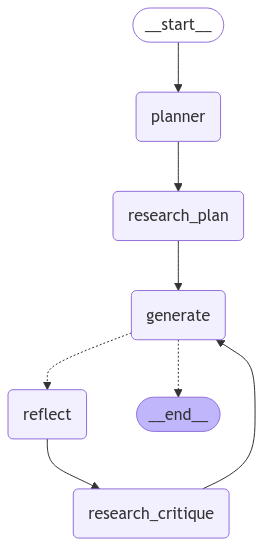

In [ ]:
from IPython.display import Image, display
display(Image(builder.compile().get_graph(xray=True).draw_mermaid_png()))

## Memory
 - We'll use a simpler built-in memory type here, but we could also connect to an sql database and store memory there
 - Threads are like separate conversations you have with the app. You could change the thread and change the topic, then change it back to the original one and continue off

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

In [ ]:
# from langgraph.checkpoint.sqlite import SqliteSaver
# memory = SqliteSaver.from_conn_string(":memory:")

In [ ]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference in challenges drilling operations face in Mining and Oil&gas",  #essay topic
    "max_revisions": 2,  # how many essay revisions do we want
    "revision_number": 1,  #start with revision #1
}, thread):
    # print(s)  # I comment printing out everything in the state memory, since I want a more structured printouts
    print('---'*10)

---------------
Plan Node. 

messages: [SystemMessage(content='You are an expert writer tasked with writing a high level outline of an essay. Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes or instructions for the sections.', additional_kwargs={}, response_metadata={}), HumanMessage(content='what is the difference in challenges drilling operations face in Mining and Oil&gas', additional_kwargs={}, response_metadata={})]

response.content: ## Essay Outline: Contrasting Drilling Challenges in Mining and Oil & Gas

**I. Introduction**

*   **Hook:** Start with a compelling statistic or anecdote highlighting the scale and importance of drilling in both mining and oil & gas industries.  Emphasize the inherent differences in their objectives.
*   **Background:** Briefly define drilling in both contexts (mineral extraction vs. hydrocarbon extraction).  Mention the overarching goal of each industry (resource acquisition).
*   **Thes